# Pore and Surface Diffusion Model (PSDM)

Originally developed by Michigan Technological University, coded in Python by USEPA

This can be used to model granular activated carbon (GAC) systems.

#  6.2 Alternative fouling approach

author: Jonathan Burkhardt @UCChEJBB,
         Levi Haupert
         
PFHpA data from article: 

*Modeling PFAS Removal Using Granular Activated Carbon for Full-Scale System Design*
         
edit: Mathieu Coghe, highlighted by *//Mathieu* (Ctrl+F)

In [1]:
## Import Required Packages
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import pylab as plt

import os
srt_dir = os.getcwd()

import PSDM
os.chdir(srt_dir)

//Mathieu: self calculated b1 =  PFHpA    0.43565
dtype: float64
//Mathieu: self calculated b2 =  PFHpA    0.360309
dtype: float64


In [2]:
fn = '6.2_Input_PFHpA.xlsx'

chem_data = PSDM.process_input_data(fn, sheet_name='Properties') 
k_data = pd.read_excel(fn, sheet_name='Kdata',index_col=0) # K & 1/n data

raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )

In [3]:
raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data_variable',\
                                               column_sheet='columnSpecs'
                                              )
## User can look at raw_data to see new variable influent, or 
## see "data_variable" sheet


Edits are made in *PSDM.py* highlighted by *//Mathieu* (Ctrl+F)
- Additional equation for bed weight reduction
- Make sure that K is not reduced if alternative fouling is desired (use default from *PSDM_functions.py*)

Below: insert % bed weight reduction

PFHpA
//Mathieu self.chem_type:  halogenated alkenes
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  PFHpA    1.0
dtype: float64
rk2:  PFHpA    0.0
dtype: float64
rk3:  PFHpA    0.0
dtype: float64
rk4:  PFHpA    0.0
dtype: float64
//Mathieu: k_mult_pd:  [1. 1. 1. 1. 1.]  ...
EBCT:  9.88  min
//Mathieu self.chem_type:  PFAS
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    0.43565
dtype: float64
b2:  PFHpA    0.360309
dtype: float64
rk1:  PFHpA    0.512787
dtype: float64
rk2:  PFHpA   -2.679248e-08
dtype: float64
rk3:  PFHpA    0.283173
dtype: float64
rk4:  PFHpA   -0.000039
dtype: float64
//Mathieu: k_mult_pd:  [0.79595906 0.73885526 0.69320457 0.65670365 0.62751237]  ...
//Mathieu self.chem_type:  Fouling alternative (70%)
//Mathieu: % bed weight reduction:  70
//Mathieu: you want alternative fouling calculation:
//Mathieu: fouling parameters:
a1:  1.

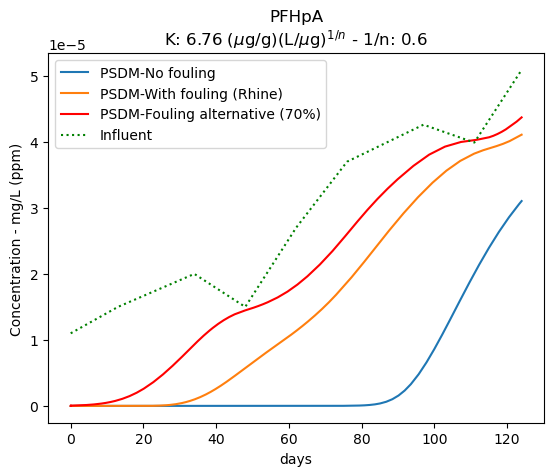

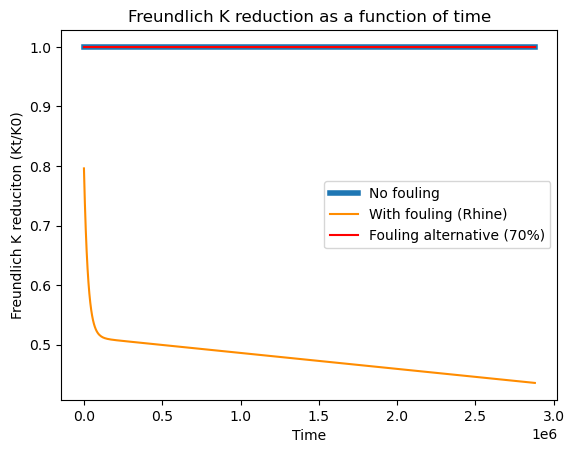

In [4]:
#//Mathieu: alternative fouling calculation:
chem_type1 = 'PFAS'
water_type1 = 'Rhine'

chem_type2 = 'Fouling alternative (70%)'
water_type2 = 'Fouling alternative (70%)'

#note additional inputs in definition of column, below.

for comp in compounds:
    print(comp)
    
    # SETTING UP PSDM simulation column
    column = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    print('EBCT: ', round(column.ebct, 2), ' min') 
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    column2 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   chem_type=chem_type1,
                   water_type=water_type1,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)
    
    column3 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   chem_type=chem_type2,
                   water_type=water_type2,
                   optimize=False
                   )
    
    column3.test_range = np.array([k_data[comp]['K']])
    column3.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results3 = column3.run_psdm_kfit(comp)    
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-No fouling')
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-With fouling ('+water_type1+')')
    plt.plot(results3.index, 
             results3.values/1000., 
             label='PSDM-'+water_type2,
             color='red')    
    (raw_data[column.influent][comp]/1000.).plot.line(label='Influent',linestyle=':',color='green')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    plt.figure()
    plt.plot(column.K_time, 
             column.K_mult_time, 
             label='No fouling',
             linewidth=4)
    plt.plot(column2.K_time, 
             column2.K_mult_time,
             label='With fouling ('+water_type1+')',
             color='darkorange')    
    plt.plot(column3.K_time, 
             column3.K_mult_time,
             label=water_type2,
             color='red')
    
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot
    plt.xlabel('Time')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis    
    plt.grid(False)  # Disable grid
    plt.show()  # Display the plot    
    
    tab2 = 'model-'+comp
    
    with pd.ExcelWriter('Example_TCE_' + carbons[0] + '_example2.xlsx') as writer:
        results.to_excel(writer, sheet_name=tab2)



In [5]:
column.chem_type,column2.chem_type,column3.chem_type

('halogenated alkenes', 'PFAS', 'halogenated alkenes')

In [6]:
column.wt,column2.wt,column3.wt

(4349.9508283000005, 4349.9508283000005, 1304.9852484900002)

In [7]:
#Help of ChatGPT on how to extract number (see PSDM.py)

import re

# Example string
s = "There are 123% apples in the basket."

# Regular expression to find numbers
numbers = re.findall(r'\d+', s)

# Convert the first extracted number from string to integer
if numbers:
    number = int(numbers[0])
    print(number)

123


In [8]:
column_info

,F400
rad,0.0513
flrt,984.207064
epor,0.641
psdfr,5.0
rhop,0.803
rhof,0.62
L,120.0
wt,4349.950828
diam,10.155936
tortu,1.0


## Constant influent

In [9]:
raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )
## User can look at raw_data to see new variable influent, or 
## see "data_variable" sheet


PFHpA
//Mathieu self.chem_type:  halogenated alkenes
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  PFHpA    1.0
dtype: float64
rk2:  PFHpA    0.0
dtype: float64
rk3:  PFHpA    0.0
dtype: float64
rk4:  PFHpA    0.0
dtype: float64
//Mathieu: k_mult_pd:  [1. 1. 1. 1. 1.]  ...
EBCT:  9.88  min
//Mathieu self.chem_type:  PFAS
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    0.43565
dtype: float64
b2:  PFHpA    0.360309
dtype: float64
rk1:  PFHpA    0.512787
dtype: float64
rk2:  PFHpA   -2.679248e-08
dtype: float64
rk3:  PFHpA    0.283173
dtype: float64
rk4:  PFHpA   -0.000039
dtype: float64
//Mathieu: k_mult_pd:  [0.79595906 0.73885526 0.69320457 0.65670365 0.62751237]  ...
//Mathieu self.chem_type:  Fouling alternative (50.8271%)
//Mathieu: % bed weight reduction:  50
//Mathieu: you want alternative fouling calculation:
//Mathieu: fouling parameters:
a1

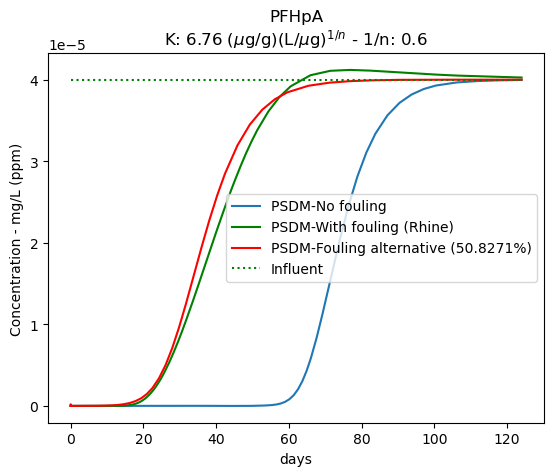

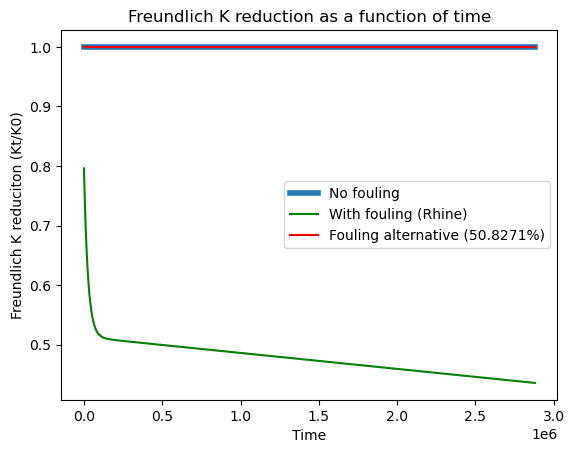

In [10]:
#//Mathieu: alternative fouling calculation:
chem_type1 = 'PFAS'
water_type1 = 'Rhine'

chem_type2 = 'Fouling alternative (50.8271%)'
water_type2 = 'Fouling alternative (50.8271%)'

#note additional inputs in definition of column, below.

for comp in compounds:
    print(comp)
    
    # SETTING UP PSDM simulation column
    column = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    print('EBCT: ', round(column.ebct, 2), ' min') 
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    column2 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   chem_type=chem_type1,
                   water_type=water_type1,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)
    
    column3 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   chem_type=chem_type2,
                   water_type=water_type2,
                   optimize=False
                   )
    
    column3.test_range = np.array([k_data[comp]['K']])
    column3.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results3 = column3.run_psdm_kfit(comp)    
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-No fouling')
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-With fouling ('+water_type1+')',
             color='green')
    plt.plot(results3.index, 
             results3.values/1000., 
             label='PSDM-'+water_type2,
             color='red')    
    (raw_data[column.influent][comp]/1000.).plot.line(label='Influent',linestyle=':',color='green')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    plt.figure()
    plt.plot(column.K_time, 
             column.K_mult_time, 
             label='No fouling',
             linewidth=4)
    plt.plot(column2.K_time, 
             column2.K_mult_time,
             label='With fouling ('+water_type1+')',
             color='green')    
    plt.plot(column3.K_time, 
             column3.K_mult_time,
             label=water_type2,
             color='red')
    
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot
    plt.xlabel('Time')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis    
    plt.grid(False)  # Disable grid
    plt.show()  # Display the plot    
    
    tab2 = 'model-'+comp
    
    with pd.ExcelWriter('Example_TCE_' + carbons[0] + '_example2.xlsx') as writer:
        results.to_excel(writer, sheet_name=tab2)

